In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MaxAbsScaler, RobustScaler, Normalizer
from sklearn.model_selection import GridSearchCV
import os

from pathlib import Path
import pickle

from surrogates.system import SystemSurrogate
from utils import ax_default

In [2]:
# Load the full SystemSurrogate
# save_dir = 'build_2023-07-18T01.48.39'
save_dir = 'build_2023-08-11T23.09.43'
base_dir = Path('../../results/surrogates')
root_dir = base_dir / save_dir
surr = SystemSurrogate.load_from_file(root_dir / 'sys' / 'sys_final.pkl', root_dir=root_dir)
surr.set_output_dir({'Thruster': None})  # Don't save outputs for testing
sys_qoi = [1, 2, 3]
thruster_qoi = [i-1 for i in sys_qoi]

2023-08-14 12:10:08,339 — [INFO] — surrogates.system.SystemSurrogate    — SystemSurrogate loaded from C:\Users\eckel\Documents\GitHub\HallThrusterPEM\results\surrogates\build_2023-08-11T23.09.43\sys\sys_final.pkl


In [52]:
# Load training set
thruster = surr['Thruster']
xdim, ydim = len(thruster.x_vars), thruster.ydim
xtrain, ytrain = np.empty((0, xdim)), np.empty((0, ydim))
files = [f for f in os.listdir(root_dir / 'components' / 'Thruster') if f.endswith('.pkl')]
for f in files:
    with open(root_dir / 'components' / 'Thruster' / f, 'rb') as fd:
        data = pickle.load(fd)
        xtrain = np.concatenate((xtrain, data['x']), axis=0)
        ytrain = np.concatenate((ytrain, data['y']), axis=0)
nan_idx = np.any(np.isnan(ytrain), axis=-1)
xtrain, ytrain = xtrain[~nan_idx, :], ytrain[~nan_idx, :]
ytrain = ytrain[:, thruster_qoi]
xtrain.shape, ytrain.shape

((969, 11), (969, 3))

In [68]:
for alpha, yi_dict in thruster.yi_nan_map.items():
    for coord, yi in yi_dict.items():
        print(f'xi: {thruster.xi_map[alpha][coord]} yi: {thruster.yi_map[alpha][coord]}')

xi: [-6.0000000e+00  3.0000000e+02  2.0000017e+00  3.0000000e+00
  4.9999988e+02  2.0000000e-01  1.0500000e+01 -2.9999993e+00
  1.0000029e+01  7.9999998e-02  3.0000000e+01] yi: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan]
xi: [-6.0000000e+00  3.0000000e+02  2.0000017e+00  3.0000000e+00
  4.9999988e+02  2.0000000e-01  1.0000060e+00 -2.9999993e+00
  5.5000000e+01  7.9999998e-02  3.0000000e+01] yi: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan]
xi: [-6.0000000e+00  2.0000006e+02  2.0000017e+00  3.0000000e+00
  4.9999988e+02  2.0000000e-01  1.0500000e+01 -2.9999993e+00
  5.5000000e+01  7.9999998e-02  3.0000000e+01] yi: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan]


In [54]:
# Load system test set
with open(Path('../../models/data') / 'test_set.pkl', 'rb') as fd:
    data = pickle.load(fd)
    xtest_sys, ytest_sys = data['xt'], data['yt']
xtest_sys.shape, ytest_sys.shape

((874, 21), (874, 38))

In [55]:
# Get system surrogate prediction
yt_surr = surr(xtest_sys)
yt_surr = yt_surr[:, sys_qoi]   # (Nt, Nq)
yt_surr.shape

(874, 3)

In [57]:
# Convert test set to thruster inputs/outputs
exo_in = surr.graph.nodes['Thruster']['exo_in']
global_in = surr.graph.nodes['Thruster']['global_in']
xtest = np.concatenate((xtest_sys[:, exo_in], ytest_sys[:, global_in]), axis=-1)    # (Nt, 11)
ytest = ytest_sys[:, sys_qoi]                                                       # (Nt, Nq)
xtest.shape, ytest.shape

((874, 11), (874, 3))

Training set R2 values: [0.50641217 0.87312125 0.89911851]. Uniform average: 0.7595506399472592
Relative L2 error on test set: [0.08092358 0.1482191  0.1811409 ]


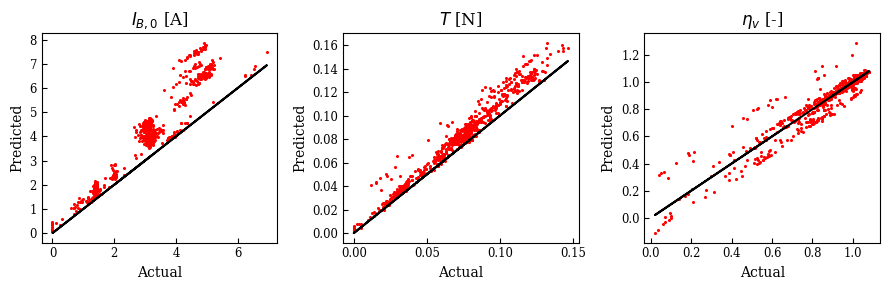

In [66]:
# Test MISC surrogate on training set
model = surr.get_component('Thruster')
ytrain_ridge = model(xtrain)[:, thruster_qoi]
r2 = 1 - np.sum((ytrain_ridge - ytrain)**2, axis=0) / np.sum((ytrain_ridge - np.mean(ytrain_ridge, axis=0))**2, axis=0)
rel_error = np.sqrt(np.mean((ytest - yt_surr)**2, axis=0)) / np.sqrt(np.mean(ytest**2, axis=0))     # (Nq,)
print(f'Training set R2 values: {r2}. Uniform average: {np.mean(r2)}')
print(f'Relative L2 error on test set: {rel_error}')

fig, axs = plt.subplots(1, len(sys_qoi))
labels = [surr.coupling_vars[i].to_tex(units=True) for i in sys_qoi]
for i in range(len(sys_qoi)):
    ax = axs[i] if len(sys_qoi) > 1 else axs
    ax.scatter(ytrain[:, i], ytrain_ridge[:, i], c='r', s=1.5)
    ax.plot(ytrain[:, i], ytrain[:, i], '-k')
    ax.set_title(labels[i])
    ax_default(ax, 'Actual', 'Predicted', legend=False)
fig.set_size_inches(3*len(sys_qoi), 3)
fig.tight_layout()
plt.show()

Training set R2 values: [0.92007765 0.83854917 0.26081022]. Uniform average: 0.6731456787007427
Relative L2 error on test set: [0.27477883 0.16894699 0.16591772]


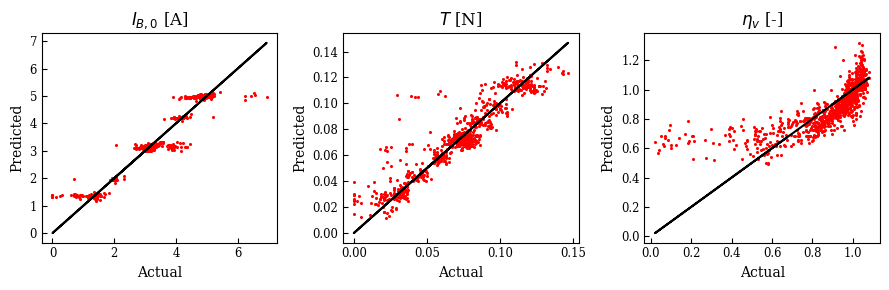

In [60]:
# Test scikit-learn regression
model = Ridge(alpha=0.1)
model.fit(xtrain, ytrain)
yt_ridge = model.predict(xtest)
ytrain_ridge = model.predict(xtrain)
r2 = 1 - np.sum((ytrain_ridge - ytrain)**2, axis=0) / np.sum((ytrain_ridge - np.mean(ytrain_ridge, axis=0))**2, axis=0)
rel_error = np.sqrt(np.mean((ytest - yt_ridge)**2, axis=0)) / np.sqrt(np.mean(ytest**2, axis=0))     # (Nq,)
print(f'Training set R2 values: {r2}. Uniform average: {np.mean(r2)}')
print(f'Relative L2 error on test set: {rel_error}')

fig, axs = plt.subplots(1, len(sys_qoi))
for i in range(len(sys_qoi)):
    ax = axs[i] if len(sys_qoi) > 1 else axs
    ax.scatter(ytrain[:, i], ytrain_ridge[:, i], c='r', s=1.5)
    ax.plot(ytrain[:, i], ytrain[:, i], '-k')
    ax.set_title(labels[i])
    ax_default(ax, 'Actual', 'Predicted', legend=False)
fig.set_size_inches(3*len(sys_qoi), 3)
fig.tight_layout()
plt.show()

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END features__degree=2, scaler=StandardScaler();, score=0.861 total time=   0.0s
[CV 2/5] END features__degree=2, scaler=StandardScaler();, score=0.829 total time=   0.0s
[CV 3/5] END features__degree=2, scaler=StandardScaler();, score=0.872 total time=   0.0s
[CV 4/5] END features__degree=2, scaler=StandardScaler();, score=0.876 total time=   0.0s
[CV 5/5] END features__degree=2, scaler=StandardScaler();, score=0.874 total time=   0.0s
[CV 1/5] END features__degree=2, scaler=MaxAbsScaler();, score=0.845 total time=   0.0s
[CV 2/5] END features__degree=2, scaler=MaxAbsScaler();, score=0.826 total time=   0.0s
[CV 3/5] END features__degree=2, scaler=MaxAbsScaler();, score=0.866 total time=   0.0s
[CV 4/5] END features__degree=2, scaler=MaxAbsScaler();, score=0.864 total time=   0.0s
[CV 5/5] END features__degree=2, scaler=MaxAbsScaler();, score=0.853 total time=   0.0s
[CV 1/5] END features__degree=3, scaler=StandardSc

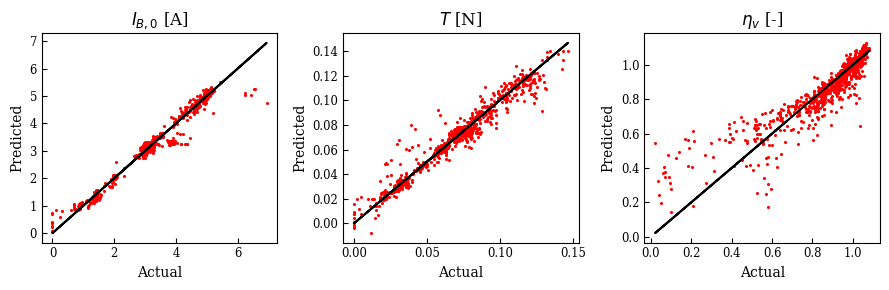

In [61]:
# Test scikit-learn regression
pipe = Pipeline([('scaler', StandardScaler()),
                  ('features', PolynomialFeatures()),
                  ('model', Ridge(alpha=1))])
params = {'features__degree': [2, 3, 4],
          'scaler': [StandardScaler(), MaxAbsScaler()]
          }
model = GridSearchCV(pipe, params, cv=5, verbose=3)
model.fit(xtrain, ytrain)
yt_ridge = model.predict(xtest)
ytrain_ridge = model.predict(xtrain)
r2 = 1 - np.sum((ytrain_ridge - ytrain)**2, axis=0) / np.sum((ytrain_ridge - np.mean(ytrain_ridge, axis=0))**2, axis=0)
rel_error = np.sqrt(np.mean((ytest - yt_ridge)**2, axis=0)) / np.sqrt(np.mean(ytest**2, axis=0))     # (Nq,)
print(f'Training set R2 values: {r2}. Uniform average: {np.mean(r2)}')
print(f'Relative L2 error on test set: {rel_error}')

fig, axs = plt.subplots(1, len(sys_qoi))
for i in range(len(sys_qoi)):
    ax = axs[i] if len(sys_qoi) > 1 else axs
    ax.scatter(ytrain[:, i], ytrain_ridge[:, i], c='r', s=1.5)
    ax.plot(ytrain[:, i], ytrain[:, i], '-k')
    ax.set_title(labels[i])
    ax_default(ax, 'Actual', 'Predicted', legend=False)
fig.set_size_inches(3*len(sys_qoi), 3)
fig.tight_layout()
plt.show()

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END model__alpha=0.01, model__kernel__length_scale=0.01;, score=-11.863 total time=   0.0s
[CV 2/5] END model__alpha=0.01, model__kernel__length_scale=0.01;, score=-9.336 total time=   0.0s
[CV 3/5] END model__alpha=0.01, model__kernel__length_scale=0.01;, score=-9.494 total time=   0.0s
[CV 4/5] END model__alpha=0.01, model__kernel__length_scale=0.01;, score=-11.163 total time=   0.0s
[CV 5/5] END model__alpha=0.01, model__kernel__length_scale=0.01;, score=-9.002 total time=   0.0s
[CV 1/5] END model__alpha=0.01, model__kernel__length_scale=0.1;, score=-5.953 total time=   0.0s
[CV 2/5] END model__alpha=0.01, model__kernel__length_scale=0.1;, score=-3.797 total time=   0.0s
[CV 3/5] END model__alpha=0.01, model__kernel__length_scale=0.1;, score=-4.343 total time=   0.0s
[CV 4/5] END model__alpha=0.01, model__kernel__length_scale=0.1;, score=-4.499 total time=   0.0s
[CV 5/5] END model__alpha=0.01, model__kernel__leng

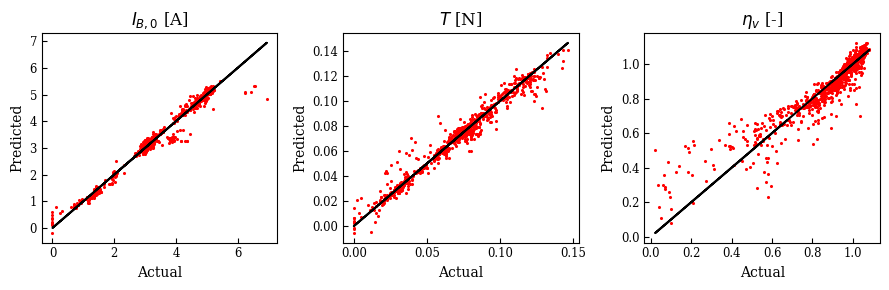

In [62]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, RBF

pipe = Pipeline([('scaler', MaxAbsScaler()),
                  ('model', GaussianProcessRegressor(n_restarts_optimizer=0, kernel=RBF(length_scale_bounds='fixed')))])
params = {'model__alpha': [1e-2, 1e-1],
          'model__kernel__length_scale': [0.01, 0.1, 1, 10]
          }
model = GridSearchCV(pipe, params, cv=5, verbose=3)
model.fit(xtrain, ytrain)
r2 = model.score(xtrain, ytrain)
yt_ridge = model.predict(xtest)
ytrain_ridge = model.predict(xtrain)
r2 = 1 - np.sum((ytrain_ridge - ytrain)**2, axis=0) / np.sum((ytrain_ridge - np.mean(ytrain_ridge, axis=0))**2, axis=0)
rel_error = np.sqrt(np.mean((ytest - yt_ridge)**2, axis=0)) / np.sqrt(np.mean(ytest**2, axis=0))     # (Nq,)
print(f'Training set R2 values: {r2}. Uniform average: {np.mean(r2)}')
print(f'Relative L2 error on test set: {rel_error}')

fig, axs = plt.subplots(1, len(sys_qoi))
for i in range(len(sys_qoi)):
    ax = axs[i] if len(sys_qoi) > 1 else axs
    ax.scatter(ytrain[:, i], ytrain_ridge[:, i], c='r', s=1.5)
    ax.plot(ytrain[:, i], ytrain[:, i], '-k')
    ax.set_title(labels[i])
    ax_default(ax, 'Actual', 'Predicted', legend=False)
fig.set_size_inches(3*len(sys_qoi), 3)
fig.tight_layout()
plt.show()

Iteration 1, loss = 1.79360469
Iteration 2, loss = 1.44747199
Iteration 3, loss = 1.15445491
Iteration 4, loss = 0.92434399
Iteration 5, loss = 0.74459984
Iteration 6, loss = 0.61552100
Iteration 7, loss = 0.51488792
Iteration 8, loss = 0.44051653
Iteration 9, loss = 0.38128803
Iteration 10, loss = 0.33709826
Iteration 11, loss = 0.29929314
Iteration 12, loss = 0.27050085
Iteration 13, loss = 0.24820007
Iteration 14, loss = 0.23063911
Iteration 15, loss = 0.21950576
Iteration 16, loss = 0.21177357
Iteration 17, loss = 0.20713218
Iteration 18, loss = 0.20395725
Iteration 19, loss = 0.20222660
Iteration 20, loss = 0.20094504
Iteration 21, loss = 0.19982848
Iteration 22, loss = 0.19880705
Iteration 23, loss = 0.19771806
Iteration 24, loss = 0.19658929
Iteration 25, loss = 0.19544090
Iteration 26, loss = 0.19429714
Iteration 27, loss = 0.19313261
Iteration 28, loss = 0.19189095
Iteration 29, loss = 0.19066560
Iteration 30, loss = 0.18948250
Iteration 31, loss = 0.18821685
Iteration 32, los

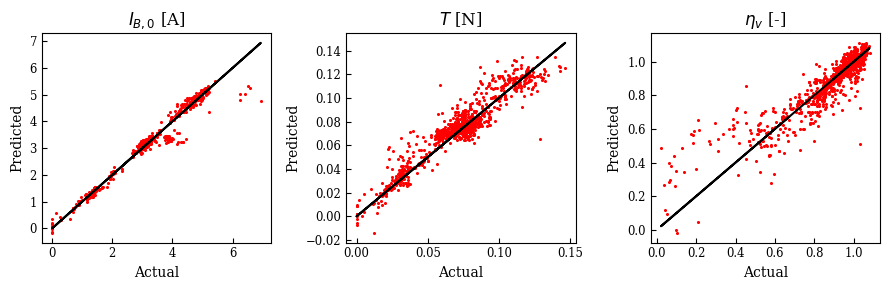

In [64]:
from sklearn.neural_network import MLPRegressor

pipe = Pipeline([('scaler', MaxAbsScaler()),
                  ('model', MLPRegressor(activation='tanh', hidden_layer_sizes=(50, 10), alpha=1e-2, learning_rate_init=0.001, max_iter=4000, verbose=True, tol=1e-12, batch_size=256, n_iter_no_change=50, validation_fraction=0.1))])
# params = {'model__hidden_layer_sizes': [(20, 10), (20, 10, 5), (50, 30, 10), (10, 5)],
#           'model__alpha': [1e-4, 1e-3, 1e-2, 1e-1],
#           'model__learning_rate_init': [1e-3, 1e-2, 1e-1]
#           }
# model = GridSearchCV(pipe, params, cv=10, verbose=3)
model = pipe
model.fit(xtrain, ytrain)
r2 = model.score(xtrain, ytrain)
yt_ridge = model.predict(xtest)
ytrain_ridge = model.predict(xtrain)
r2 = 1 - np.sum((ytrain_ridge - ytrain)**2, axis=0) / np.sum((ytrain_ridge - np.mean(ytrain_ridge, axis=0))**2, axis=0)
rel_error = np.sqrt(np.mean((ytest - yt_ridge)**2, axis=0)) / np.sqrt(np.mean(ytest**2, axis=0))     # (Nq,)
print(f'Training set R2 values: {r2}. Uniform average: {np.mean(r2)}')
print(f'Relative L2 error on test set: {rel_error}')

fig, axs = plt.subplots(1, len(sys_qoi))
for i in range(len(sys_qoi)):
    ax = axs[i] if len(sys_qoi) > 1 else axs
    ax.scatter(ytrain[:, i], ytrain_ridge[:, i], c='r', s=1.5)
    ax.plot(ytrain[:, i], ytrain[:, i], '-k')
    ax.set_title(labels[i])
    ax_default(ax, 'Actual', 'Predicted', legend=False)
fig.set_size_inches(3*len(sys_qoi), 3)
fig.tight_layout()
plt.show()

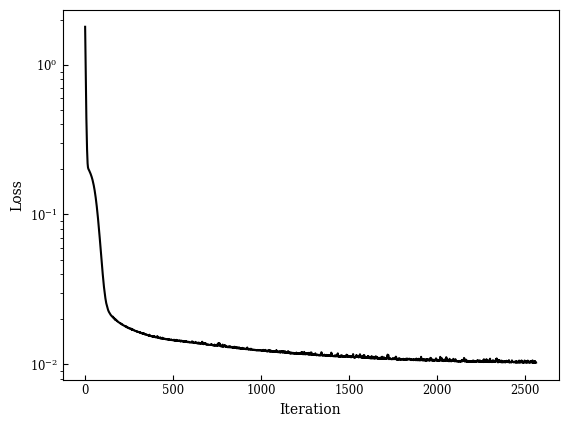

In [65]:
l = model['model'].loss_curve_
fig, ax = plt.subplots()
ax.plot(l, '-k')
ax.set_yscale('log')
ax_default(ax, 'Iteration', 'Loss', legend=False)
plt.show()

In [96]:
# Find what is causing negative thrust and NaN cases
import os
save_dir = 'build_2023-07-18T01.48.39'
root_dir = Path('../surrogates') / save_dir / 'components' / 'Thruster'
x = np.zeros((0, 14))
y = np.zeros((0, 26))
for f in os.listdir(root_dir):
    if f.endswith('.pkl'):
        with open(root_dir / f, 'rb') as fd:
            data = pickle.load(fd)
            x = np.concatenate((x, data['x']), axis=0)
            y = np.concatenate((y, data['y']), axis=0)
x.shape, y.shape

((6476, 14), (6476, 26))

In [108]:
nan_idx = np.where(np.any(np.isnan(y), axis=-1))[0]
neg_idx = np.where(y[:, 1] < 0)[0]
nan_idx.shape, neg_idx.shape

((77,), (121,))

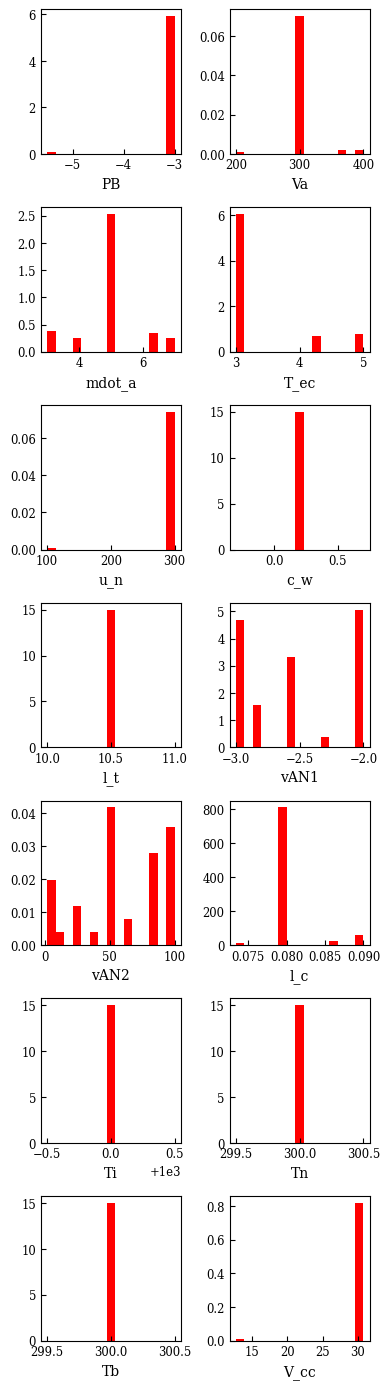

In [135]:
fig, axs = plt.subplots(7, 2)
curr_idx = 0
thruster_idx = [0, 1, 2, 3, 7, 8, 9, 10, 11, 12, 13, 14, 15]
labels = [str(var) for i, var in enumerate(surr.exo_vars) if i in thruster_idx] + ['V_cc']
for i in range(7):
    for j in range(2):
        ax = axs[i, j]
        ax.hist(x[nan_idx, curr_idx], color='red', linewidth=1.2, density=True, bins=15)
        ax_default(ax, labels[curr_idx], '', legend=False)
        curr_idx += 1
fig.set_size_inches(4, 14)
fig.tight_layout()
plt.show()